In [1]:
import pandas as pd
import geopandas as gpd
import shapely 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# Associate crimes with neighborhoods

Here we associate crimes with neighborhoods, and retain all relevant fields for downstream analysis on the way. The neighborhoods we use here will be the Chicago community areas, which are meaningful regions (things like Hyde Park instead of Ward 15 or Zip code 60637) which are also found in use in other data sources.

The crimes are not tagged with Community Areas. Most are tagged with latitude/longitude from which we can derive the community areas. Those that are missing lat/lng information are approximated from the Police Beat, the most granular level of location outside of the Block. The block is not used because it would require a street map (overkill).

<p><font color="red"><b>Warning: Consumes a lot of RAM -- 16GB recommended to run this notebook</b></font></p>

## Shape of crimes data (quickly)

In [2]:
# Raw data ingest
raw_crimes_big = pd.read_csv('./data/chicago_crime_data.csv')

In [3]:
raw_crimes_big.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,7685111,HS484316,08/27/2010 10:00:00 AM,058XX W DIVERSEY AVE,031A,ROBBERY,ARMED: HANDGUN,GROCERY FOOD STORE,False,False,...,30.0,19.0,03,1136766.0,1918012.0,2010,02/04/2016 06:33:39 AM,41.931184,-87.772831,"(41.931184467, -87.772830927)"
1,7685114,HS457262,08/11/2010 03:10:00 PM,063XX S CAMPBELL AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,15.0,66.0,19,1160796.0,1862497.0,2010,02/04/2016 06:33:39 AM,41.778381,-87.686063,"(41.778380602, -87.686062637)"
2,7685119,HS490207,08/30/2010 03:50:00 PM,018XX N RICHMOND ST,1350,CRIMINAL TRESPASS,TO STATE SUP LAND,"SCHOOL, PUBLIC, GROUNDS",True,False,...,35.0,22.0,26,1156527.0,1912063.0,2010,02/04/2016 06:33:39 AM,41.914482,-87.700374,"(41.914482493, -87.700373861)"
3,7685120,HS491229,08/31/2010 08:00:00 AM,041XX W MELROSE ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,True,True,...,31.0,16.0,08B,1148306.0,1921289.0,2010,02/04/2016 06:33:39 AM,41.939962,-87.730338,"(41.939961992, -87.730338452)"
4,7685121,HS423475,07/22/2010 06:00:00 AM,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,GOVERNMENT BUILDING/PROPERTY,True,False,...,41.0,76.0,18,1100088.0,1926079.0,2010,02/04/2016 06:33:39 AM,41.953900,-87.907473,"(41.953900467, -87.907472601)"


In [4]:
df_MB = raw_crimes_big.memory_usage()/1e6

In [5]:
print('Memory usage:')
print('Total = ' + str(df_MB.sum()))
print()
print('Breakdown:')
print(df_MB)

Memory usage:
Total = 1040.119298

Breakdown:
Index                    0.000080
ID                      51.363912
Case Number             51.363912
Date                    51.363912
Block                   51.363912
IUCR                    51.363912
Primary Type            51.363912
Description             51.363912
Location Description    51.363912
Arrest                   6.420489
Domestic                 6.420489
Beat                    51.363912
District                51.363912
Ward                    51.363912
Community Area          51.363912
FBI Code                51.363912
X Coordinate            51.363912
Y Coordinate            51.363912
Year                    51.363912
Updated On              51.363912
Latitude                51.363912
Longitude               51.363912
Location                51.363912
dtype: float64


## Reducing memory usage

This dataframe is very big. To make it more tractable... memorywise... we will remove unwanted columns. Without doing this, the analysis below easily consumes over 10gb of RAM. We can bring this down by a factor of 3.

In [6]:
cols_to_keep = ['Date', 'Arrest', 'Domestic', 'FBI Code', 'IUCR', 'Beat', 
                'Location Description', 'Latitude', 'Longitude', 'Year']

raw_crimes = raw_crimes_big[cols_to_keep].copy()

# free that memory
del raw_crimes_big 

In [7]:
df_MB = raw_crimes.memory_usage()/1e6
print('Memory usage:')
print('Total = ' + str(df_MB.sum()))
print()
print('Breakdown:')
print(df_MB)

Memory usage:
Total = 423.752354

Breakdown:
Index                    0.000080
Date                    51.363912
Arrest                   6.420489
Domestic                 6.420489
FBI Code                51.363912
IUCR                    51.363912
Beat                    51.363912
Location Description    51.363912
Latitude                51.363912
Longitude               51.363912
Year                    51.363912
dtype: float64


## Cleaning and formatting the crime data

An important column is not entirely populated... the coordinates. In these cases, we use the most granular thing we know (the beat) and randomly sample within it. This is an approximation to correctly attribute crimes without precise lat/lng tagging to neighborhoods. In general, this affects roughly 1 - 5% of total records, depending on the year.

In [8]:
yr_check = raw_crimes.groupby('Year').count()
print('Fraction of incidents without location by year:')
1 - yr_check['Latitude']/yr_check['FBI Code']

Fraction of incidents without location by year:


Year
2001    0.005869
2002    0.031259
2003    0.008148
2004    0.004598
2005    0.008290
2006    0.005609
2007    0.002909
2008    0.016300
2009    0.016720
2010    0.004300
2011    0.002124
2012    0.003059
2013    0.008223
2014    0.019372
2015    0.013849
2016    0.063109
2017    0.036373
dtype: float64

In [9]:
yr_check

,Date,Arrest,Domestic,FBI Code,IUCR,Beat,Location Description,Latitude,Longitude
Year,,,,,,,,,
2001,485732,485732,485732,485732,485732,485732,485730,482881,482881
2002,486741,486741,486741,486741,486741,486741,486737,471526,471526
2003,475917,475917,475917,475917,475917,475917,475915,472039,472039
2004,469358,469358,469358,469358,469358,469358,469349,467200,467200
2005,453683,453683,453683,453683,453683,453683,453676,449922,449922
2006,448059,448059,448059,448059,448059,448059,448048,445546,445546
2007,436959,436959,436959,436959,436959,436959,436952,435688,435688
2008,426990,426990,426990,426990,426990,426990,426980,420030,420030
2009,392594,392594,392594,392594,392594,392594,392582,386030,386030


### Only keeping points where we can associate neighborhoods

The crimes are not tagged by neighborhood. We can associate to neighborhood in cases where we have lat/lng data -- but not all incidents contain this information (though about 98% do). For those that don't, we can approximate the crime location by randomly sampling from within the police beat, the lowest level of granularity geo-tagging available behind the lat/lng.

In cases where we don't have an existing beat associated with the incident AND we don't have lat/lng data, drop the rows. We could iteratively apply the same logic and approximate from the ward level, but this has it's own caveats (i.e. the wards were restruck, effective in 2015) and would only give us clarity on 5 in 10000 crimes. Not worth the effort.

In [10]:
# for filling in missing crime locations
beat_shapes = gpd.read_file('./data/chicago_beat_geo_data.json')
beats_geo_dict_arb_keys = beat_shapes.set_index('beat_num')['geometry'].to_dict()
beats_geo_dict = { int(key) : beats_geo_dict_arb_keys[key] for key in beats_geo_dict_arb_keys}

In [11]:
entries_without_loc_or_beat =\
    raw_crimes['Latitude'].isnull() & raw_crimes['Beat'].map(lambda beat: beat not in beats_geo_dict)

In [12]:
print('beats no longer in map:')
print(sorted([ beat for beat in raw_crimes['Beat'].unique() if beat not in beats_geo_dict]))
print()
print('percent of crimes w/o location in a beat not on map:', entries_without_loc_or_beat.sum()/len(raw_crimes))

beats no longer in map:
[134, 310, 430, 1311, 1312, 1313, 1322, 1323, 1324, 1331, 1332, 1333, 2111, 2112, 2113, 2122, 2123, 2124, 2131, 2132, 2133, 2311, 2312, 2313, 2322, 2323, 2324, 2331, 2332, 2333]

percent of crimes w/o location in a beat not on map: 0.000532669707868


In [13]:
crimes_with_loc_tags = raw_crimes[entries_without_loc_or_beat == False].copy().reset_index()

### Fill in missing locations from beat

As mentioned above, when we don't have precise location data we don't know which neighborhood the crime occurred in -- and neighborhoods are the target crime representation since they're easy references for a narrative. Police beats are small compared to other available tags (like ward or district), and hence sampling from within one of these should give us a reasonable approximation for neighborhood.

Note, we do have block data for all incidents. However, to use this data to identify neighborhood we would need a street map, which due to the fact that this effect is now far on the margin, is not worth the complexity.

In [14]:
import random
random.seed(1337)

def sample_within_beat(beat_poly):
    x_min, y_min, x_max, y_max = beat_poly.bounds
    while True:
        candidate = shapely.geometry.Point([random.uniform(x_min, x_max), random.uniform(y_min, y_max)])
        if beat_poly.contains(candidate):
            return candidate   
        
def points_filled_by_beat(latitude, longitude, beat_num, beat_dict):
    if np.isnan(latitude) or np.isnan(longitude):
        return sample_within_beat(beat_dict[beat_num])
    else:
        return shapely.geometry.Point([longitude, latitude])

In [15]:
crime_points = [\
   points_filled_by_beat(crimes_with_loc_tags['Latitude'][i], 
                         crimes_with_loc_tags['Longitude'][i], 
                         crimes_with_loc_tags['Beat'][i], 
                         beats_geo_dict)\
   for i in range(len(crimes_with_loc_tags))\
]

In [16]:
temp_latlng = pd.DataFrame({ 'lng' : [ pt.x for pt in crime_points ], 'lat' : [ pt.y for pt in crime_points ] })

In [17]:
# save intermediate step ... the analysis is heavy and long in it's batch form
temp_latlng.to_csv('./cache/temp_latlng.csv')

In [18]:
#temp_latlng = pd.read_csv('./cache/temp_latlng.csv')

### Tag crimes by neighborhood

Grab the series of points from Lat / Lng crime data, then produce series of neighborhoods

Some help from (here and the section after)...
* http://geopandas.org/mergingdata.html
* https://gis.stackexchange.com/questions/190903/assign-a-point-to-polygon-using-pandas-and-shapely
* http://blog.yhat.com/posts/interactive-geospatial-analysis.html

#### Shape of neighborhood data (quickly)



In [19]:
# Use "community areas" as neighborhoods 
# note there is a neighborhoods file that's slightly different, but community areas are more meaningful
#   and other sources, such as some census aggregations, use these lines
neighborhoods = gpd.read_file('./data/chicago_commarea_geo_data.json')

In [20]:
neighborhoods.describe()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
count,77,77,77,77,77,77,77,77,77,77
unique,77,1,77,1,77,77,1,1,77,77
top,OAKLAND,0,16995983.2737,0,52,52,0,0,49213.4217488,(POLYGON ((-87.60157012805959 41.6862093549865...
freq,1,77,1,77,1,1,77,77,1,1


Hyde park stomping grounds


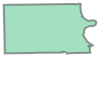

In [21]:
hp_loc = neighborhoods.index[neighborhoods['community'] == 'HYDE PARK'][0]
print('Hyde park stomping grounds')
neighborhoods['geometry'][hp_loc]

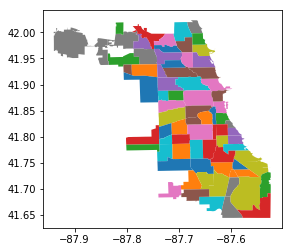

In [22]:
neighborhoods.plot(column = 'community')
plt.show()

#### Back to tagging neighborhoods

In [23]:
crime_points_gdf = gpd.GeoDataFrame({'geometry' : crime_points})
# Declare the coordinate system for the places GeoDataFrame
# GeoPandas doesn't do any transformations automatically when performing
# the spatial join. The layers are already in the same CRS (WGS84) so no
# transformation is needed.
crime_points_gdf.crs = {'init': 'epsg:4326'}

In [24]:
crimes_by_neighb = gpd.sjoin(crime_points_gdf, neighborhoods, how='left')

In [25]:
# save intermediate step ... the analysis is heavy and long in it's batch form
crimes_by_neighb[['community']].to_csv('./cache/temp_neighb_assoc.csv')

In [26]:
#crimes_by_neighb = pd.read_csv('./cache/temp_neighb_assoc.csv')

#### Take a quick look at counts

In [27]:
neighb_with_count =\
    crimes_by_neighb.groupby('community')[['index_right']].count().join(neighborhoods.set_index('community'))

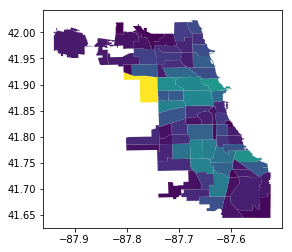

In [28]:
gpd.GeoDataFrame(neighb_with_count).plot(column = 'index_right')
plt.show()

## Use FBI crime classification

The FBI NIBRS crime classification is the one of preference in the current context because it is an aggregate / summary-level crime tagging.

Descriptions obtained from http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html

In [29]:
nibrs_map = pd.read_csv('./data/nibrs_map.csv')

In [30]:
crime_nibrs_descr = pd.merge(crimes_with_loc_tags[['FBI Code']], 
                             nibrs_map, 
                             left_on='FBI Code', 
                             right_on = 'code', 
                             how = 'left')

In [31]:
print('integrity check that number of rows stayed constant:', len(crime_nibrs_descr) == len(crimes_with_loc_tags))

integrity check that number of rows stayed constant: True


In [32]:
crime_nibrs_descr.head()

,FBI Code,code,description,is_index,crime_type
0,03,03,Robbery,True,Property
1,19,19,Gambling,False,Society
2,26,26,Misc Non-Index Offense,False,Society
3,08B,08B,Simple Battery,False,Violent
4,18,18,Drug Abuse,False,Society


In [33]:
crimes_with_loc_tags.head()

,index,Date,Arrest,Domestic,FBI Code,IUCR,Beat,Location Description,Latitude,Longitude,Year
0,0,08/27/2010 10:00:00 AM,False,False,03,031A,2514,GROCERY FOOD STORE,41.931184,-87.772831,2010
1,1,08/11/2010 03:10:00 PM,True,False,19,1661,825,SIDEWALK,41.778381,-87.686063,2010
2,2,08/30/2010 03:50:00 PM,True,False,26,1350,1421,"SCHOOL, PUBLIC, GROUNDS",41.914482,-87.700374,2010
3,3,08/31/2010 08:00:00 AM,True,True,08B,0486,1731,RESIDENCE,41.939962,-87.730338,2010
4,4,07/22/2010 06:00:00 AM,True,False,18,1812,1654,GOVERNMENT BUILDING/PROPERTY,41.953900,-87.907473,2010


## Combining it all (so far)

Some of the data at this point is either redundant or not useful for downstream analysis. Here we will select and cast data in the appropriate way given downstream use cases.

In [34]:
crimes_with_loc_tags.dtypes

index                     int64
Date                     object
Arrest                     bool
Domestic                   bool
FBI Code                 object
IUCR                     object
Beat                      int64
Location Description     object
Latitude                float64
Longitude               float64
Year                      int64
dtype: object

In [35]:
cleaned_crimes_intermediate = pd.DataFrame({
    'date'              : crimes_with_loc_tags['Date'],
    'year'              : crimes_with_loc_tags['Year'].map(int),
    'crime_description' : crime_nibrs_descr['description'].map(str),
    'crime_is_index'    : crime_nibrs_descr['is_index'].map(bool),
    'crime_type'        : crime_nibrs_descr['crime_type'].map(str),
    'location_details'  : crimes_with_loc_tags['Location Description'].map(str),
    'arrest'            : crimes_with_loc_tags['Arrest'],
    'domestic'          : crimes_with_loc_tags['Domestic'],
    'iucr'              : crimes_with_loc_tags['IUCR'].map(str),
    'lat'               : temp_latlng['lat'].map(float),
    'lng'               : temp_latlng['lng'].map(float),
    'neighborhood'      : crimes_by_neighb['community']
})

## Location tagging

Some of the locations either represent a very small portion of crimes or are somewhat redundant. Here we tag locations at a coarser level for more meaningful and synthesized downstream analysis.

The approach is to first classify all locations not contributing meaningfully to a crime statistic as Other, and then to bucket the remaining locations based on their descriptions (for example, Residence and Residence-Garage are both Residence). Significance is determined by comparing the maximum contribution to a given crime classification against a threshold.

In [36]:
crimes_by_loc = cleaned_crimes_intermediate\
    .groupby(['crime_description', 'location_details'])[['date']]\
    .count()\
    .rename(columns = {'date' : 'count'})\
    .reset_index()\
    .pivot(index = 'location_details', columns = 'crime_description', values = 'count')\
    .fillna(0)
crimes_by_loc_pct = crimes_by_loc.div(crimes_by_loc.sum(axis=0), axis=1)

Below we plot crimes by location as a percentage of occurrence for each crime category. The big takeaway here is it is very, very sparse.

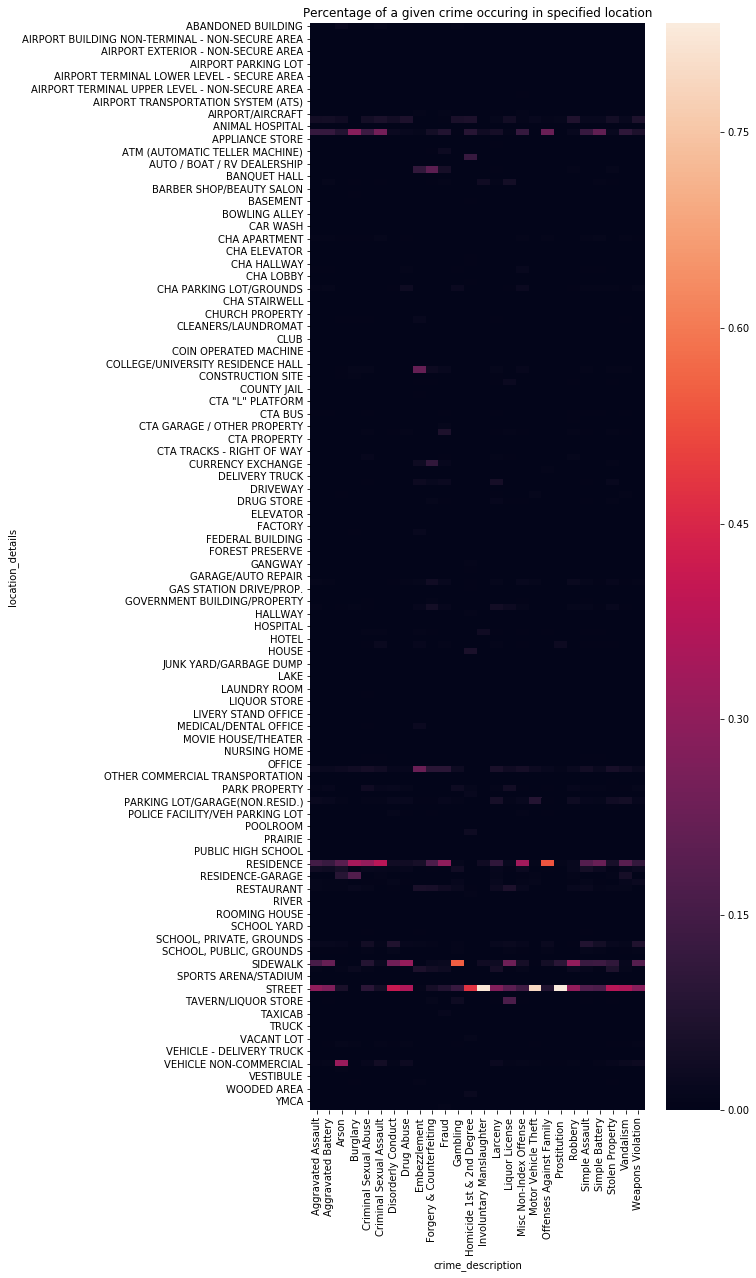

In [37]:
plt.figure(figsize = (7.5, 20))
sns.heatmap(crimes_by_loc_pct)
plt.title('Percentage of a given crime occuring in specified location')
plt.show()

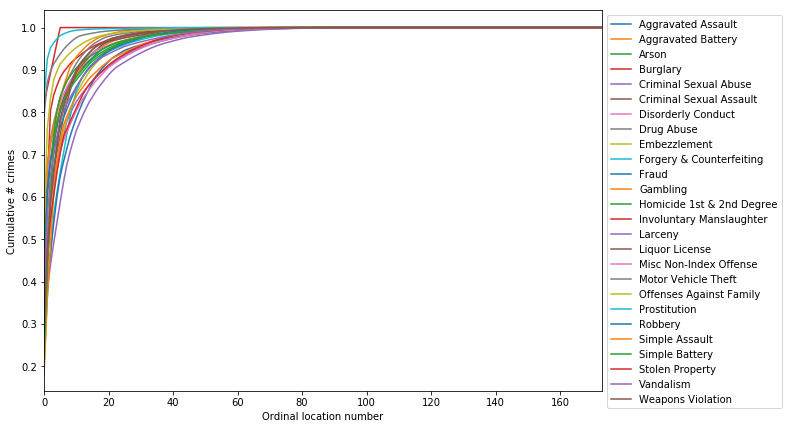

In [38]:
cum_pct_crime = crimes_by_loc_pct.apply(lambda col: np.cumsum(sorted(col, reverse=True))).reset_index(drop=True)
cum_pct_crime.plot(figsize=(10, 7)).legend(bbox_to_anchor=(1, 1))
plt.xlabel('Ordinal location number')
plt.ylabel('Cumulative # crimes')
plt.show()

Based on the above, lets keep any feature contributing at least 2% to any given crime. We don't want this threshold to be so small that we have tons of one-off locations, but we also don't want it to be so large that everything becomes "Other".

In [39]:
location_contribution_threshold = 0.02

In [40]:
loc_with_more_than_thresh = crimes_by_loc_pct.apply(max, axis = 1) > location_contribution_threshold
crimes_by_loc_pct[loc_with_more_than_thresh]

crime_description,Aggravated Assault,Aggravated Battery,Arson,Burglary,Criminal Sexual Abuse,Criminal Sexual Assault,Disorderly Conduct,Drug Abuse,Embezzlement,Forgery & Counterfeiting,...,Misc Non-Index Offense,Motor Vehicle Theft,Offenses Against Family,Prostitution,Robbery,Simple Assault,Simple Battery,Stolen Property,Vandalism,Weapons Violation
location_details,,,,,,,,,,,,,,,,,,,,,
ALLEY,0.040852,0.042393,0.033671,0.001123,0.043211,0.060330,0.039828,0.064793,0.000000,0.002068,...,0.008189,0.016681,0.007287,0.011890,0.070281,0.016620,0.018793,0.045200,0.017571,0.066710
APARTMENT,0.117613,0.119571,0.077367,0.285720,0.133379,0.246608,0.025369,0.017109,0.012734,0.042537,...,0.119157,0.001672,0.225827,0.001673,0.017373,0.122141,0.207923,0.016436,0.101425,0.063141
ATM (AUTOMATIC TELLER MACHINE),0.000040,0.000012,0.000095,0.000008,0.000000,0.000000,0.000022,0.000006,0.002996,0.004107,...,0.000071,0.000003,0.000000,0.000000,0.000865,0.000020,0.000013,0.000000,0.000126,0.000000
AUTO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BANK,0.000300,0.000071,0.000284,0.000180,0.000550,0.000070,0.000303,0.000041,0.110112,0.197404,...,0.001650,0.000040,0.000039,0.000015,0.007327,0.001549,0.000221,0.010459,0.001266,0.000093
BAR OR TAVERN,0.003036,0.011929,0.003121,0.003445,0.002784,0.004697,0.001862,0.000295,0.002996,0.006261,...,0.002130,0.000106,0.000000,0.000059,0.001380,0.003069,0.009207,0.003362,0.002472,0.001381
CHA PARKING LOT/GROUNDS,0.009057,0.012779,0.001135,0.000343,0.001822,0.001079,0.006277,0.030248,0.001498,0.000603,...,0.023260,0.002143,0.001136,0.000415,0.003507,0.007336,0.007009,0.009339,0.003351,0.011747
COMMERCIAL / BUSINESS OFFICE,0.001488,0.000632,0.004918,0.012919,0.011069,0.001287,0.000606,0.000129,0.215730,0.028118,...,0.013669,0.000796,0.000313,0.000755,0.001385,0.007124,0.001732,0.007097,0.008481,0.000621
CONVENIENCE STORE,0.002187,0.000826,0.001892,0.001720,0.000756,0.000000,0.000779,0.000450,0.005243,0.006032,...,0.003049,0.000056,0.000118,0.000000,0.004566,0.002941,0.000982,0.003362,0.001035,0.000900


Some themese are emerging right away which are captured in the dictionary mapping below. NOte we would catch the majority of cases if we just mapped the 34 categories above, but there are additional good-faith mapping specifications.

* Retail
* Residence
* Street
* Vehicle
* Bank
* Office
* Medical center

In [41]:
crimes_by_loc_pct[loc_with_more_than_thresh].index.values

array(['ALLEY', 'APARTMENT', 'ATM (AUTOMATIC TELLER MACHINE)', 'AUTO',
       'BANK', 'BAR OR TAVERN', 'CHA PARKING LOT/GROUNDS',
       'COMMERCIAL / BUSINESS OFFICE', 'CONVENIENCE STORE', 'CTA PLATFORM',
       'CURRENCY EXCHANGE', 'DEPARTMENT STORE', 'GAS STATION',
       'GROCERY FOOD STORE', 'HOSPITAL BUILDING/GROUNDS', 'HOTEL/MOTEL',
       'HOUSE', 'MEDICAL/DENTAL OFFICE', 'OTHER', 'PARK PROPERTY',
       'PARKING LOT/GARAGE(NON.RESID.)', 'PORCH', 'RESIDENCE',
       'RESIDENCE PORCH/HALLWAY', 'RESIDENCE-GARAGE',
       'RESIDENTIAL YARD (FRONT/BACK)', 'RESTAURANT',
       'SCHOOL, PUBLIC, BUILDING', 'SIDEWALK', 'SMALL RETAIL STORE',
       'STREET', 'TAVERN/LIQUOR STORE', 'VEHICLE NON-COMMERCIAL', 'YARD'], dtype=object)

In [42]:
all_locs = set(crimes_by_loc_pct.index.values)

In [43]:
inverse_loc_map = {
    'RETAIL' : ['CONVENIENCE STORE', 'CURRENCY EXCHANGE', 'DEPARTMENT STORE', 'GAS STATION', 
                'GROCERY FOOD STORE', 'SMALL RETAIL STORE'],
    'RESIDENCE' : ['APARTMENT', 'HOUSE', 'PORCH', 'YARD'] +\
                  list(filter(lambda x: x[:3] == 'CHA', all_locs)) +\
                  list(filter(lambda x: 'RESID' in x, all_locs)),
    'STREET' : ['ALLEY', 'PARK PROPERTY', 'SIDEWALK', 'STREET'],
    'PUBLIC BUILDING' : ['CTA PLATFORM', 'PARKING LOT/GARAGE(NON.RESID.)', 'SCHOOL, PUBLIC, BUILDING'],
    'VEHICLE' : ['AUTO', 'VEHICLE NON-COMMERCIAL'],
    'BANK' : ['ATM (AUTOMATIC TELLER MACHINE)', 'BANK'],
    'OFFICE' : ['COMMERCIAL / BUSINESS OFFICE'],
    'MEDICAL CENTER' : ['HOSPITAL BUILDING/GROUNDS', 'MEDICAL/DENTAL OFFICE'],
    'HOSPITALITY' : ['BAR OR TAVERN', 'HOTEL/MOTEL', 'RESTAURANT', 'TAVERN/LIQUOR STORE'] 
}

explicit_locs  = { orig_loc : loc for loc in inverse_loc_map for orig_loc in inverse_loc_map[loc] }
remaining_locs = { orig_loc : 'OTHER' for orig_loc in filter(lambda x: x not in explicit_locs, all_locs) }
loc_map = {**explicit_locs, **remaining_locs}

### A look at the new location tagging

We've just updated our location mapping. Lets apply this to the nearly cleaned data and take a quick look at the distributions of crimes by location.

In [44]:
cleaned_crimes = cleaned_crimes_intermediate.copy()
cleaned_crimes['location'] = cleaned_crimes['location_details'].map(lambda loc: loc_map[loc])

In [45]:
crimes_by_loc_final = cleaned_crimes\
    .groupby(['crime_description', 'location'])[['date']]\
    .count()\
    .rename(columns = {'date' : 'count'})\
    .reset_index()\
    .pivot(index = 'location', columns = 'crime_description', values = 'count')\
    .fillna(0)
crimes_by_loc_final_pct = crimes_by_loc_final.div(crimes_by_loc.sum(axis=0), axis=1)

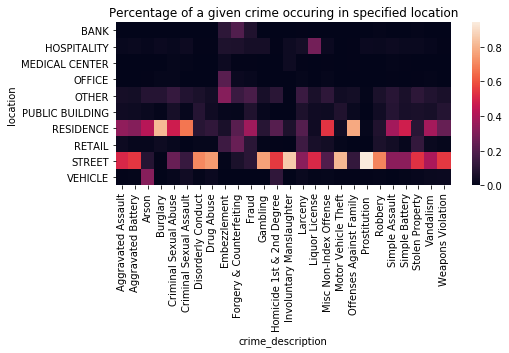

In [46]:
plt.figure(figsize = (7.5, 3))
sns.heatmap(crimes_by_loc_final_pct)
plt.title('Percentage of a given crime occuring in specified location')
plt.show()

## Output

In [47]:
cleaned_crimes.to_csv('./data/cleaned_crimes.csv')